Paper tham khảo:
- Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan: **Show and tell: A neural image caption generator**. CVPR 2015: 3156-3164 ([Link](https://arxiv.org/abs/1411.4555))
- 	Kelvin Xu, Jimmy Ba, Ryan Kiros, Kyunghyun Cho, Aaron C. Courville, Ruslan Salakhutdinov, Richard S. Zemel, Yoshua Bengio: **Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.** ICML 2015: 2048-2057 ([Link](https://arxiv.org/abs/1502.03044))
-   Mingxing Tan, Quoc V. Le: **EfficientNetV2: Smaller Models and Faster Training**. ICML 2021: 10096-10106
-   Xiaohan Ding, Xiangyu Zhang, Ningning Ma, Jungong Han, Guiguang Ding, Jian Sun: **RepVGG: Making VGG-Style ConvNets Great Again.** CVPR 2021: 13733-13742
-   Alexey Bochkovskiy, Chien-Yao Wang, Hong-Yuan Mark Liao: **YOLOv4: Optimal Speed and Accuracy of Object Detection**. CoRR abs/2004.10934 (2020) [Link
](https://arxiv.org/abs/2004.10934)
- 	Quan Hoang Lam, Quang-Duy Le, Kiet Van Nguyen, Ngan Luu-Thuy Nguyen: **UIT-ViIC: A Dataset for the First Evaluation on Vietnamese Image Captioning.** ICCCI 2020: 730-742 ([Link](https://arxiv.org/abs/2002.00175))
-   Kishore Papineni, Salim Roukos, Todd Ward, Wei-Jing Zhu: **Bleu: a Method for Automatic Evaluation of Machine Translation.** ACL 2002: 311-318 [Link](https://dl.acm.org/doi/10.3115/1073083.1073135)
-   Ramakrishna Vedantam, C. Lawrence Zitnick, Devi Parikh: **CIDEr: Consensus-based image description evaluation.** CVPR 2015: 4566-4575 [Link](https://arxiv.org/abs/1411.5726)

##Tải dataset (nếu dùng colab)

In [ ]:
!kaggle datasets download -d vitngquang/uit-viic-v1-0-vietnamese-image-captioning

Dataset URL: https://www.kaggle.com/datasets/vitngquang/uit-viic-v1-0-vietnamese-image-captioning
License(s): other
100% 1.23G/1.23G [01:05<00:00, 22.0MB/s]
100% 1.23G/1.23G [01:05<00:00, 20.3MB/s]


In [ ]:
!unzip -q uit-viic-v1-0-vietnamese-image-captioning.zip

##Import các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, concatenate, add, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from transformers import AutoModel, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import torch
from textwrap import wrap
import matplotlib.pyplot as plt

## Load data và tiền xử lý dữ liệu

In [ ]:
def load_data(path):
    with open(path + 'captions.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = [line.split('\t', 1) for line in lines]
    df = pd.DataFrame(data, columns=["image_path", "caption"])

    return df

### Load train, val, test data

In [ ]:
#dataset_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset' # nếu dùng kaggle
dataset_path = '/content/dataset'
train_path = dataset_path + '/train/'
val_path = dataset_path + '/val/'
test_path = dataset_path + '/test/'

In [ ]:
df_train = load_data(train_path)
df_val = load_data(val_path)
df_test = load_data(test_path)

In [ ]:
df_train

,image_path,caption
0,/dataset/train/images/000000157656.jpg,Người đàn ông đang đánh tennis ngoài sân.\n
1,/dataset/train/images/000000157656.jpg,Một vận động viên tennis đang vung vợt đánh bó...
2,/dataset/train/images/000000157656.jpg,Một cầu thủ tennis đang vung vợt tennis đỡ bón...
3,/dataset/train/images/000000157656.jpg,Người đàn ông đang đứng ngoài biên cầm vợt sẵn...
4,/dataset/train/images/000000157656.jpg,Vận động viên tennis nam đang trong tư thế chu...
...,...,...
13476,/dataset/train/images/000000121943.jpg,Những cô gái đang chơi bóng đá ở trên sân .\n
13477,/dataset/train/images/000000466840.jpg,Những người đàn ông đang chơi bóng chày trên s...
13478,/dataset/train/images/000000381377.jpg,Một số người mặc đồ đá bóng đang đá bóng trên ...
13479,/dataset/train/images/000000561746.jpg,Một người đàn ông đang dùng vợt để đánh quả bó...


### Tiền xử lý dữ liệu


In [ ]:
def text_preprocessing(df):
    df_preprocessed = df.copy()
    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: x.lower())
    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: x.replace("\s+"," "))
    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    df_preprocessed['caption'] = "startseq "+df_preprocessed['caption']+" endseq"
    df_preprocessed['image_path'] = df_preprocessed['image_path'].str.replace('^/dataset', '', regex=True)
    df_preprocessed['image_path'] = dataset_path + df_preprocessed['image_path']
    return df_preprocessed

In [ ]:
df_train_preprocessed = text_preprocessing(df_train)
df_val_preprocessed = text_preprocessing(df_val)
df_test_preprocessed = text_preprocessing(df_test)

In [ ]:
df_train_preprocessed

,image_path,caption
0,/content/dataset/train/images/000000157656.jpg,startseq người đàn ông đang đánh tennis ngoài ...
1,/content/dataset/train/images/000000157656.jpg,startseq một vận động viên tennis đang vung vợ...
2,/content/dataset/train/images/000000157656.jpg,startseq một cầu thủ tennis đang vung vợt tenn...
3,/content/dataset/train/images/000000157656.jpg,startseq người đàn ông đang đứng ngoài biên cầ...
4,/content/dataset/train/images/000000157656.jpg,startseq vận động viên tennis nam đang trong t...
...,...,...
13476,/content/dataset/train/images/000000121943.jpg,startseq những cô gái đang chơi bóng đá trên s...
13477,/content/dataset/train/images/000000466840.jpg,startseq những người đàn ông đang chơi bóng ch...
13478,/content/dataset/train/images/000000381377.jpg,startseq một số người mặc đồ đá bóng đang đá b...
13479,/content/dataset/train/images/000000561746.jpg,startseq một người đàn ông đang dùng vợt để đá...


Ví dụ 1 caption đã qua xử lý

In [ ]:
df_train_preprocessed['caption'][500]

'startseq một nữ vận động viên tennis đang xoay người để đánh bóng endseq'

Tokenize text của caption và map các từ trong câu qua One-hot encoding

In [ ]:
# train_captions = df_train_preprocessed['caption']
# vocab_size = len(tokenizer)
# max_length = max(len(caption.split()) for caption in train_captions)

# train_images = df_train_preprocessed['image_path']
# val_images = df_val_preprocessed['image_path']
captions = df_train_preprocessed['caption'].tolist() + df_val_preprocessed['caption'].tolist() + df_test_preprocessed['caption'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

train_images = df_train_preprocessed['image_path']
val_images = df_val_preprocessed['image_path']

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 7, 20, 17, 18, 5, 4, 39, 16, 10, 3, 2]

## Thiết lập mô hình

#### VGG16

In [ ]:
model = VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


#### Trích xuất thông tin từ ảnh

Kích thước mặc định của ảnh là 224x224 (VGG16), tùy chỉnh theo từng mô hình

In [ ]:
img_size = 224

In [ ]:
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
img_size = 224
features = {}
all_images = df_train_preprocessed['image_path'].unique().tolist() + df_val_preprocessed['image_path'].unique().tolist()
for image in tqdm(all_images):
    img = load_img(image,target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 3619/3619 [04:38<00:00, 12.97it/s]


In [ ]:
np.savez("features.npz", **features) # lưu features trích xuất từ các images về máy

### Custom Data phù hợp cho quá trình huấn luyện mô hình

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

### Mô hình tổng thể Encoder-Decoder

Setup lại kích cỡ lớp input phù hợp với mô hình (dưới là VGG16)

In [ ]:
input1 = Input(shape=(4096,))

# Encoder
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Decoder
input2 = Input(shape=(max_length,))
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
caption_model.compile(loss='categorical_crossentropy',optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hiển thị mạng neural của mô hình tổng thể

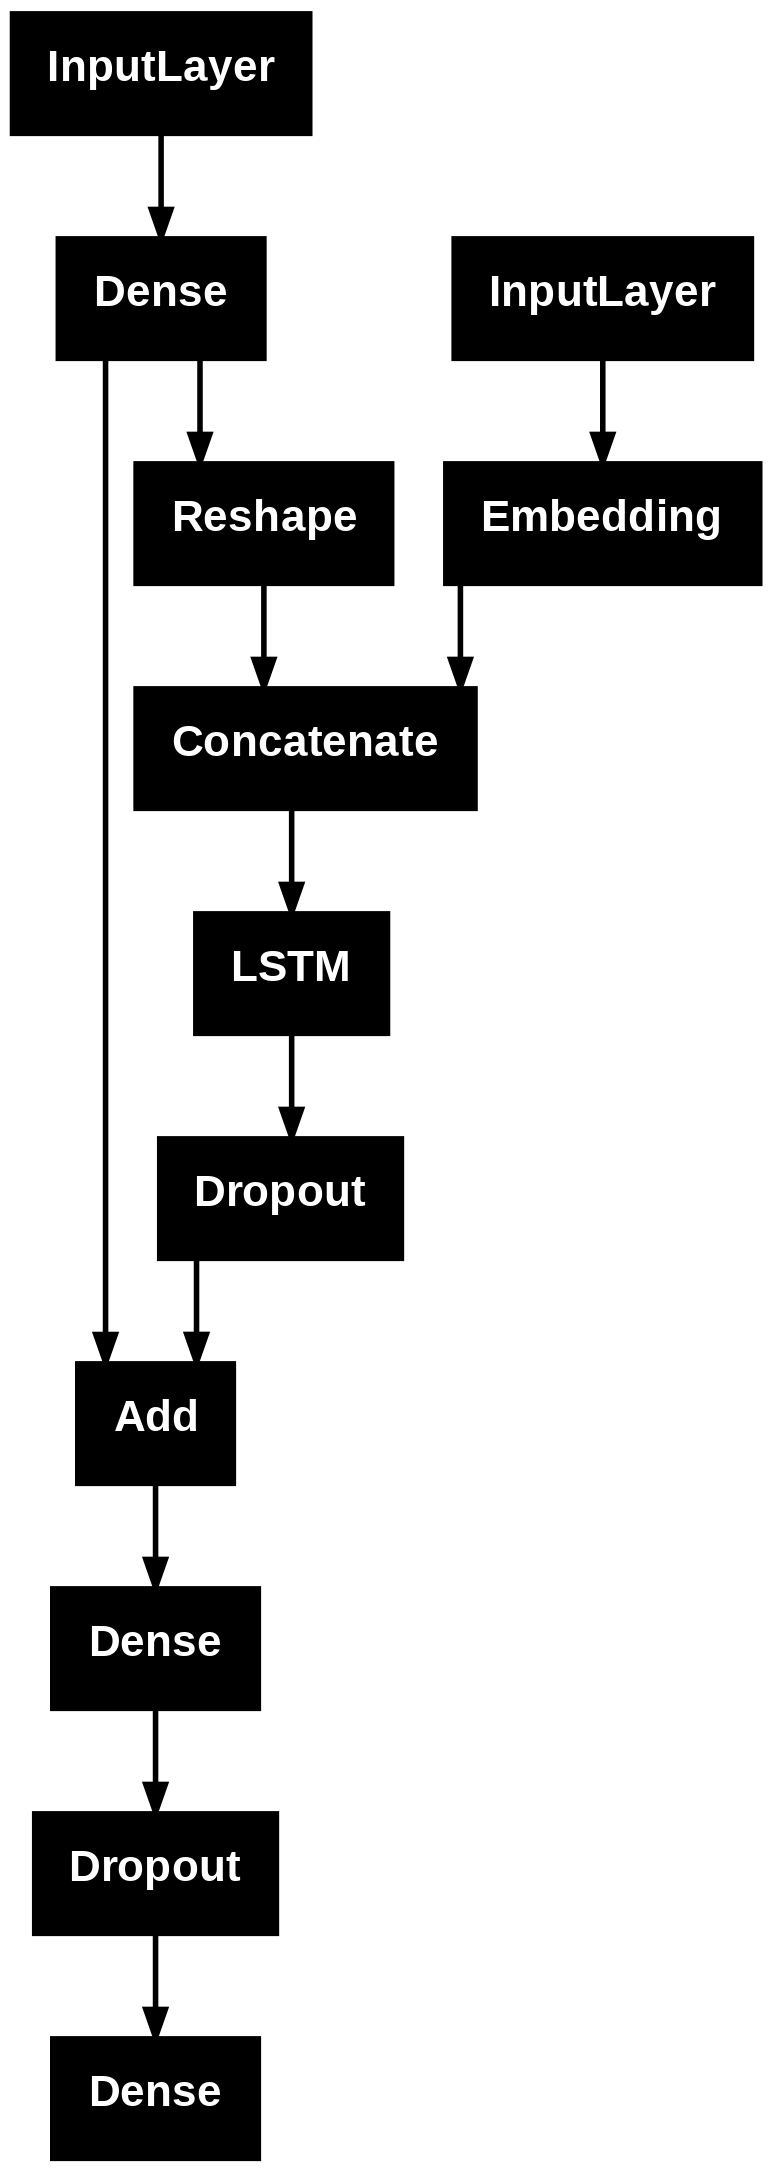

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │        345,856 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 36, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1351)           │        174,279 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,127,175 (8.11 MB)

 Trainable params: 2,127,175 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

## Huấn luyện mô hình

Tạo data phù hợp cho huấn luyện mô hình

In [ ]:
train_generator = CustomDataGenerator(df=df_train_preprocessed,X_col='image_path',y_col='caption',batch_size=64,directory=None,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=df_val_preprocessed,X_col='image_path',y_col='caption',batch_size=64,directory=None,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

Setup các tham số huấn luyện

In [ ]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

Huấn luyện mô hình (sử dụng GPU)

In [ ]:
with tf.device('/GPU:0'):
    history = caption_model.fit(
            train_generator,
            epochs=50,
            validation_data=validation_generator,
            callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 4.8987
Epoch 1: val_loss improved from inf to 2.71660, saving model to model.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - loss: 4.8903 - val_loss: 2.7166 - learning_rate: 5.0000e-04
Epoch 2/50
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.6144
Epoch 2: val_loss improved from 2.71660 to 2.02174, saving model to model.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - loss: 2.6129 - val_loss: 2.0217 - learning_rate: 5.0000e-04
Epoch 3/50
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.1128
Epoch 3: val_loss improved from 2.02174 to 1.78880, saving model to model.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - loss: 2.1121 - val_loss: 1.7888 - learning_rate: 5.0000e-04
Epoch 4/50
209/210 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.8820
Epoch 4: val_loss improved from 1.78880 to 1.66778, saving model to model.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - loss: 1.8817 - val_loss: 1.6678 - learning_rate: 5.0000

Hiển thị quá trình huấn luyện

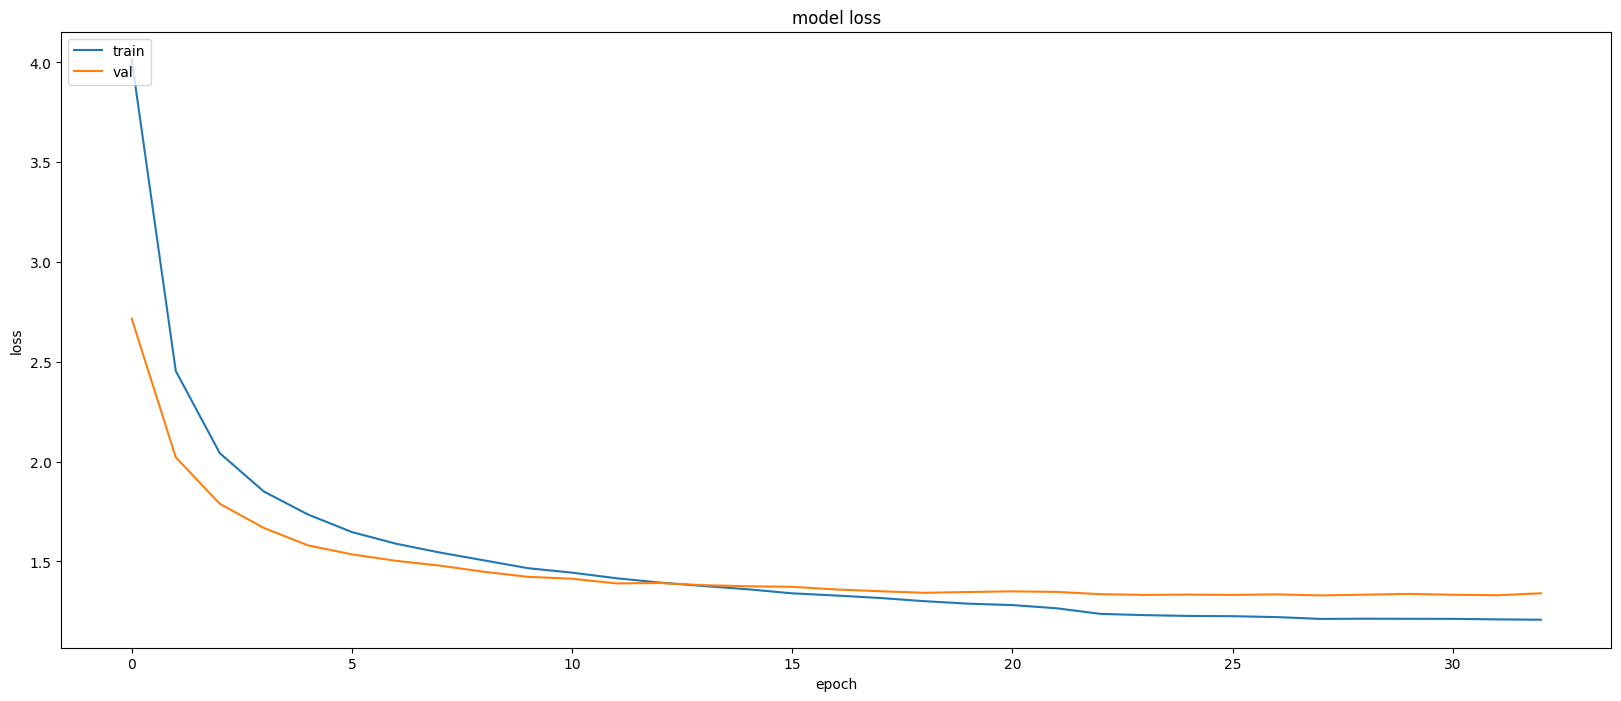

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("model.h5")

## Test mô hình

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    img = load_img(image, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

###Load model đã train và các features (optional)



In [ ]:
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

In [ ]:
df_test_preprocessed['caption'].iloc[7]

'startseq cầu thủ bóng chày nữ đang vừa chạy vừa ném quả bóng endseq'

In [ ]:
caption_model = tf.keras.models.load_model('/content/model.keras')

In [ ]:
loaded_data = np.load("/content/features.npz", allow_pickle=True)
features = dict(loaded_data)

In [ ]:
predict_caption(caption_model, df_test_preprocessed['image_path'].iloc[7], tokenizer, max_length, features)

'startseq một người đàn ông đang chuẩn bị đánh quả bóng tennis endseq'

### Thử với 15 mẫu random từ tập test

In [ ]:
samples = df_test_preprocessed.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
samples

,image_path,caption
0,/content/dataset/test/images/000000123731.jpg,startseq hai hình ảnh của một người phụ nữ đan...
1,/content/dataset/test/images/000000319731.jpg,startseq vận động viên tennis nữ đang vung vợt...
2,/content/dataset/test/images/000000473928.jpg,startseq hình ảnh trận bóng chày đang diễn ra ...
3,/content/dataset/test/images/000000335660.jpg,startseq hai hình ảnh giống nhau của hai người...
4,/content/dataset/test/images/000000375321.jpg,startseq vận động viên tennis đang cầm vợt đứn...
5,/content/dataset/test/images/000000245598.jpg,startseq đứa trẻ đang cầm gậy đỡ bóng trên sân...
6,/content/dataset/test/images/000000500740.jpg,startseq một cầu thủ bóng chày đang thi đấu tr...
7,/content/dataset/test/images/000000481168.jpg,startseq đứa trẻ đang cầm vợt tennis nhảy lên ...
8,/content/dataset/test/images/000000205086.jpg,startseq một cậu bé đang hít đất cùng quả bóng...
9,/content/dataset/test/images/000000150981.jpg,startseq một người phụ nữ đang chuẩn bị phát b...


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"{temp_df.image_path[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.predict[i], 20)))
        plt.axis("off")

In [ ]:
for index,record in samples.iterrows():

    img = load_img(record['image_path'],target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image_path'], tokenizer, max_length, features)
    samples.loc[index,'predict'] = caption

In [ ]:
# Loại bỏ 'startseq' và 'endseq' khỏi cột 'caption'
samples['predict'] = samples['predict'].str.replace(r'^startseq ', '', regex=True)
samples['predict'] = samples['predict'].str.replace(r' endseq$', '', regex=True)

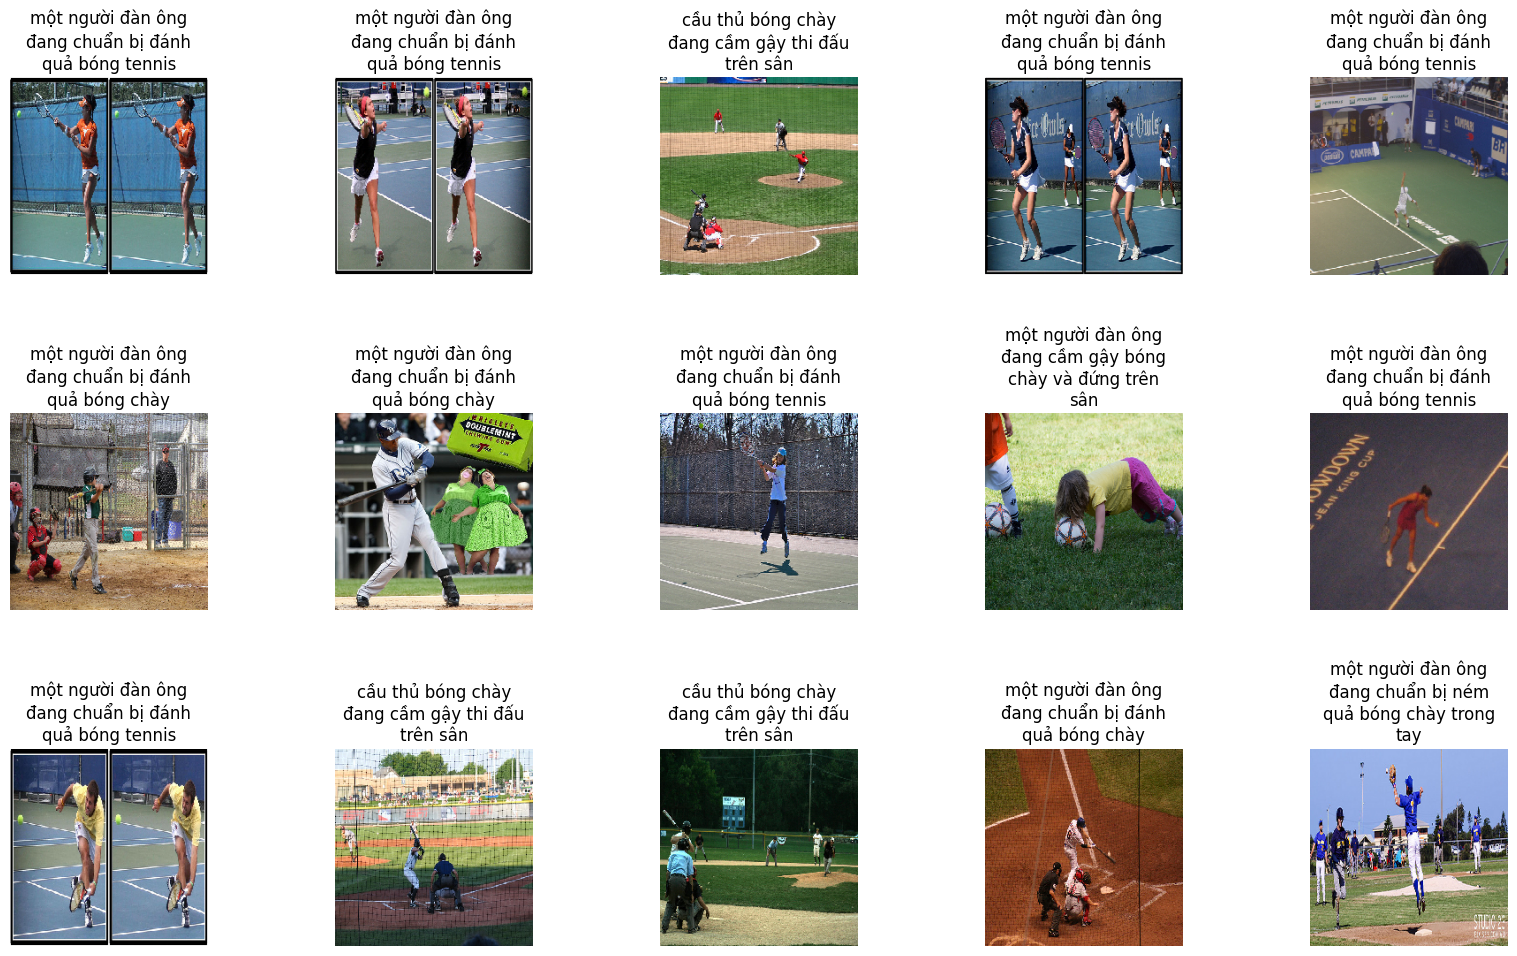

In [ ]:
display_images(samples)

## Đánh giá mô hình

### BLEU metric

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
df_test_preprocessed['caption'] = df_test_preprocessed['caption'].str.replace(r'^startseq ', '', regex=True)
df_test_preprocessed['caption'] = df_test_preprocessed['caption'].str.replace(r' endseq$', '', regex=True)

In [ ]:
df_test_merge = df_test_preprocessed.groupby('image_path')['caption'].apply(list).reset_index()

In [ ]:
df_test_merge

,image_path,caption
0,/content/dataset/test/images/000000007615.jpg,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...
1,/content/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...
2,/content/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...
3,/content/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...
4,/content/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...
...,...,...
226,/content/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...
227,/content/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...
228,/content/dataset/test/images/000000565360.jpg,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ..."
229,/content/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...


Predict

In [ ]:
for index,record in df_test_merge.iterrows():
    img = load_img(record['image_path'],target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image_path'], tokenizer, max_length, features)
    df_test_merge.loc[index,'predict'] = caption

In [ ]:
df_test_merge['predict'] = df_test_merge['predict'].str.replace(r'^startseq ', '', regex=True)
df_test_merge['predict'] = df_test_merge['predict'].str.replace(r' endseq$', '', regex=True)

In [ ]:
df_test_merge

,image_path,caption,predict
0,/content/dataset/test/images/000000007615.jpg,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...,một người đàn ông đang chuẩn bị ném quả bóng chày
1,/content/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một người đàn ông đang chuẩn bị đánh quả bóng ...
2,/content/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...,một người đàn ông đang chuẩn bị đánh quả bóng ...
3,/content/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...,một người đàn ông đang chuẩn bị đánh quả bóng ...
4,/content/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...,một người đàn ông đang chuẩn bị đánh quả bóng ...
...,...,...,...
226,/content/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...,một người đàn ông đang chuẩn bị đánh quả bóng ...
227,/content/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang chuẩn bị đánh quả bóng ...
228,/content/dataset/test/images/000000565360.jpg,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ...",những đứa trẻ đang chơi bóng đá trên sân
229,/content/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...,một người đàn ông đang chuẩn bị đánh quả bóng ...


Tính BLEU score

In [ ]:
def calculate_bleu_scores(row):
    reference = [caption.split() for caption in row['caption']]
    prediction = row['predict'].split()

    smoothie = SmoothingFunction().method4

    bleu_1 = sentence_bleu(reference, prediction, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = sentence_bleu(reference, prediction, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu_3 = sentence_bleu(reference, prediction, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu_4 = sentence_bleu(reference, prediction, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return pd.Series([bleu_1, bleu_2, bleu_3, bleu_4])

In [ ]:
df_test_merge[['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']] = df_test_merge.apply(calculate_bleu_scores, axis=1)

In [ ]:
df_test_merge

,image_path,caption,predict,bleu_1,bleu_2,bleu_3,bleu_4
0,/content/dataset/test/images/000000007615.jpg,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...,một người đàn ông đang chuẩn bị ném quả bóng chày,0.909091,0.852803,0.741515,0.563756
1,/content/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.363636,0.093379,0.050288,0.030545
2,/content/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.545455,0.330289,0.145517,0.081240
3,/content/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.818182,0.756787,0.685303,0.631555
4,/content/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.636364,0.436931,0.352462,0.269855
...,...,...,...,...,...,...,...
226,/content/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.818182,0.756787,0.685303,0.587728
227,/content/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang chuẩn bị đánh quả bóng ...,1.000000,1.000000,1.000000,1.000000
228,/content/dataset/test/images/000000565360.jpg,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ...",những đứa trẻ đang chơi bóng đá trên sân,0.695986,0.558030,0.433356,0.330101
229,/content/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.818182,0.756787,0.685303,0.587728


In [ ]:
bleu_1_avg = round(df_test_merge['bleu_1'].mean() * 100, 2)
bleu_2_avg = round(df_test_merge['bleu_2'].mean() * 100, 2)
bleu_3_avg = round(df_test_merge['bleu_3'].mean() * 100, 2)
bleu_4_avg = round(df_test_merge['bleu_4'].mean() * 100, 2)

# In kết quả BLEU score trung bình
print("Average BLEU-1 Score:", bleu_1_avg)
print("Average BLEU-2 Score:", bleu_2_avg)
print("Average BLEU-3 Score:", bleu_3_avg)
print("Average BLEU-4 Score:", bleu_4_avg)

Average BLEU-1 Score: 63.13
Average BLEU-2 Score: 47.11
Average BLEU-3 Score: 37.45
Average BLEU-4 Score: 29.76


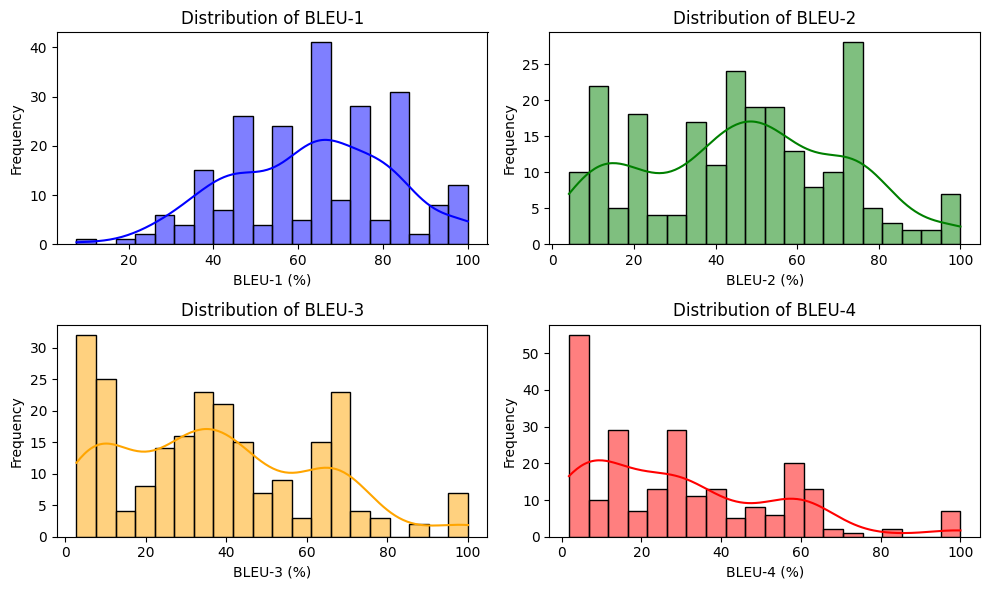

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.histplot(df_test_merge['bleu_1'] * 100, kde=True, bins=20, color='blue', label='BLEU-1')
plt.title('Distribution of BLEU-1')
plt.xlabel('BLEU-1 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df_test_merge['bleu_2'] * 100, kde=True, bins=20, color='green', label='BLEU-2')
plt.title('Distribution of BLEU-2')
plt.xlabel('BLEU-2 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df_test_merge['bleu_3'] * 100, kde=True, bins=20, color='orange', label='BLEU-3')
plt.title('Distribution of BLEU-3')
plt.xlabel('BLEU-3 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(df_test_merge['bleu_4'] * 100, kde=True, bins=20, color='red', label='BLEU-4')
plt.title('Distribution of BLEU-4')
plt.xlabel('BLEU-4 (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### ROUGE score (ROUGE-L f1-score)

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=694d36214f0714bd4f42059a19be637aa6e227ace0ffe689be6c3b8afa94dfba
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
def calculate_rouge_scores(row):
    reference = row['caption']
    prediction = row['predict']

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    total_f1 = 0

    for ref in reference:
        scores = scorer.score(ref, prediction)
        rouge_l = scores['rougeL']
        total_f1 += rouge_l.fmeasure

    avg_f1 = total_f1 / len(reference)

    return avg_f1

In [ ]:
df_test_merge['rouge_L'] = df_test_merge.apply(calculate_rouge_scores, axis=1)

In [ ]:
df_test_merge

,image_path,caption,predict,bleu_1,bleu_2,bleu_3,bleu_4,rouge_L
0,/content/dataset/test/images/000000007615.jpg,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...,một người đàn ông đang chuẩn bị ném quả bóng chày,0.909091,0.852803,0.741515,0.563756,0.517286
1,/content/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.363636,0.093379,0.050288,0.030545,0.264049
2,/content/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.545455,0.330289,0.145517,0.081240,0.356843
3,/content/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.818182,0.756787,0.685303,0.631555,0.622734
4,/content/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.636364,0.436931,0.352462,0.269855,0.432138
...,...,...,...,...,...,...,...,...
226,/content/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.818182,0.756787,0.685303,0.587728,0.743656
227,/content/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang chuẩn bị đánh quả bóng ...,1.000000,1.000000,1.000000,1.000000,0.701032
228,/content/dataset/test/images/000000565360.jpg,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ...",những đứa trẻ đang chơi bóng đá trên sân,0.695986,0.558030,0.433356,0.330101,0.395767
229,/content/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.818182,0.756787,0.685303,0.587728,0.578372


In [ ]:
rouge_avg = round(df_test_merge['rouge_L'].mean() * 100, 2)

In [ ]:
print("Average ROUGE Score:", rouge_avg)

Average ROUGE Score: 45.22
